# Inverse problems with data-driven denoisers: Examples
Demo of the plug-and-play framework for solving inverse problems with data-driven denoisers.

Part of the tutorial on inverse problems at this [event](https://bayesplurinacional.org/en/2025/index.html)

## Setup

Install Python environment

In [ ]:
!pip install torch torchvision scico bm3d gdown

Clone LPN code repository

In [1]:
!git clone https://github.com/ZhenghanFang/learned-proximal-networks learned_proximal_networks

Cloning into 'learned_proximal_networks'...
remote: Enumerating objects: 987, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 987 (delta 37), reused 30 (delta 30), pack-reused 931 (from 2)
Receiving objects: 100% (987/987), 160.39 MiB | 81.75 MiB/s, done.
Resolving deltas: 100% (218/218), done.
Updating files: 100% (525/525), done.


Download pretrained model

In [2]:
import os, gdown

file_id = "11eO5mTibFJGRLQjTjI36Vh94CZQTThmI"
output_path = "models/lpn.pt"
url = f"https://drive.google.com/uc?id={file_id}"
os.makedirs("models", exist_ok=True)
gdown.download(url, output_path, quiet=False)
print(f"Downloaded to {output_path}")

Downloading...
From (original): https://drive.google.com/uc?id=11eO5mTibFJGRLQjTjI36Vh94CZQTThmI
From (redirected): https://drive.google.com/uc?id=11eO5mTibFJGRLQjTjI36Vh94CZQTThmI&confirm=t&uuid=c55fd31d-3a66-45aa-9528-6f705b19a0c2
To: /cis/home/zfang23/code/inverse-tutorial/models/lpn.pt
100%|██████████| 86.9M/86.9M [00:01<00:00, 44.8MB/s]

Downloaded to models/lpn.pt


## Deblurring

In [23]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision.datasets import CelebA
from skimage.metrics import peak_signal_noise_ratio as skimage_psnr
from skimage.metrics import structural_similarity as skimage_ssim

import scico
import scico.numpy as snp
from scico import functional, linop, loss, plot
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.solver import cg
from scico.util import device_info

In [24]:
seed = 0
np.random.seed(seed)

Files already downloaded and verified


(-0.5, 127.5, 127.5, -0.5)

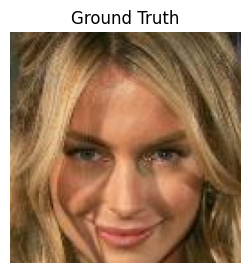

In [25]:
# Read a test image.
image_size = 128
transform = transforms.Compose(
    [
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ]
)
dataset = CelebA(root="data/celeba", split="valid", transform=transform, download=True)
idx = 101
img, _ = dataset[idx]
img = img.numpy()
img = np.transpose(img, (1, 2, 0))
plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.title("Ground Truth")
plt.axis("off")

In [26]:
# Define blurring operator
def gaussian_kernel(kernel_size=5, sigma=1.0):
    """
    creates gaussian kernel with side length `kernel_size` and a sigma of `sigma`
    """
    ax = np.linspace(-(kernel_size - 1) / 2.0, (kernel_size - 1) / 2.0, kernel_size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)


def get_kernel_size(sigma):
    """Get kernel size for Gaussian kernel given standard deviation"""
    ks = np.maximum(5, int(3 * sigma))
    if ks % 2 == 0:
        # enforce odd kernel size
        ks += 1
    return ks


def get_blur_A(sigma_blur, x_shape):
    kernel_size = get_kernel_size(sigma_blur)
    psf = np.array(gaussian_kernel(kernel_size, sigma_blur)[:, :, None])
    A = scico.linop.Convolve(h=psf, input_shape=tuple(x_shape))
    return A

In [27]:
# Create a measurement by blurring and adding Gaussian white noise.
sigma_blur = 1.0
sigma_noise = 0.04

A = get_blur_A(sigma_blur, (image_size, image_size, 3))
y = A(img)
noise = np.random.normal(0, 1, y.shape)
y = y + sigma_noise * noise
meas = np.asarray(y).astype("float32")

/cis/home/zfang23/miniconda3/envs/lpn/lib/python3.9/site-packages/scico/linop/_convolve.py:70: UserWarning: Argument 1 of 1 is an np.ndarray. Will cast it to DeviceArray. To suppress this warning cast all np.ndarrays to DeviceArray first.
  self.h = ensure_on_device(h)


In [28]:
# Define LPN model
def load_model(model_path):
    """Load LPN model for testing"""
    from learned_proximal_networks.lpn.networks.lpn_128 import LPN

    model = LPN(in_dim=3, hidden=256, alpha=1e-6, beta=100)
    model.load_state_dict(torch.load(model_path)["model_state_dict"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)
    return model


class HelperFunctional(scico.functional.Functional):
    def __init__(self, prox):
        super().__init__()
        self._prox = prox

    def prox(self, x, lam=1.0, **kwargs):
        return self._prox(x, lam=lam, **kwargs)


def get_lpn_regularizer():
    model_path = "models/lpn.pt"
    model = load_model(model_path)
    prox = lambda x, lam=1.0, **kwargs: model.apply_numpy(np.asarray(x))
    g = HelperFunctional(prox)
    return g

In [29]:
# Run PnP-ADMM with different denoisers

# ADMM arguments
rho = 0.1  # ADMM penalty parameter
maxiter = 20  # number of ADMM iterations


def run_pnp_deblurring(method):
    if method == "lpn":
        g = get_lpn_regularizer()
    elif method == "bm3d":
        lamb = sigma_noise  # BM3D regularization strength
        g = lamb * functional.BM3D()
    elif method == "dncnn":
        g = functional.DnCNN("17M")

    y = snp.array(meas)
    x0 = A.adj(y)
    f = loss.SquaredL2Loss(y=y, A=A, scale=0.5)
    g_list = [g]
    C_list = [linop.Identity(x0.shape) for _ in range(len(g_list))]
    rho_list = [rho] * len(g_list)

    solver = ADMM(
        f=f,
        g_list=g_list,
        C_list=C_list,
        rho_list=rho_list,
        x0=x0,
        maxiter=maxiter,
        subproblem_solver=LinearSubproblemSolver(
            cg_kwargs={"tol": 1e-5, "maxiter": 30}
        ),
        itstat_options={"display": True},
    )
    xhat = solver.solve()
    xhat = np.asarray(xhat)
    xhat = np.clip(xhat, 0, 1)
    return xhat


xhat_dict = {}
for method in ["bm3d", "dncnn", "lpn"]:
    print(f"Running PnP with {method} denoiser")
    xhat_dict[method] = run_pnp_deblurring(method)

Running PnP with bm3d denoiser
Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  1.84e+00  1.349e+01  8.487e+00     13  8.704e-06
   1  3.59e+00  6.287e+00  7.649e+00     13  6.448e-06
   2  5.33e+00  3.931e+00  3.037e+00     11  6.793e-06
   3  7.14e+00  2.696e+00  1.893e+00     10  6.824e-06
   4  8.85e+00  2.048e+00  1.597e+00      9  8.280e-06
   5  1.05e+01  1.658e+00  1.525e+00      9  8.054e-06
   6  1.23e+01  1.431e+00  1.548e+00      9  7.788e-06
   7  1.40e+01  1.296e+00  1.606e+00      9  6.876e-06
   8  1.57e+01  1.191e+00  1.608e+00      9  6.428e-06
   9  1.75e+01  1.180e+00  1.633e+00      9  5.971e-06
  10  1.92e+01  1.186e+00  1.702e+00      9  6.246e-06
  11  2.09e+01  1.155e+00  1.745e+00      9  6.395e-06
  12  2.26e+01  1.223e+00  1.816e+00      9  6.452e-06
  13  2.43e+01  1.221e+00  1.880e+00      9  7.040e-06
  14  2.60e+01  1.262e+00  1.926e+00      9  7.273e-06
  15  2.77e+01  1.214e+00  1.923e+

In [30]:
# Helper functions for evaluation and visualization
def center_crop(img, shape):
    """Center crop image to desired shape.
    Args:
        img: image to be cropped, (h, w, c), numpy array
        shape: desired shape, (h, w)
    Returns:
        img_crop: cropped image, (h, w, c), numpy array
    """
    h, w = img.shape[:2]
    h1, w1 = shape
    assert (h - h1) % 2 == 0 and (w - w1) % 2 == 0
    h_start = (h - h1) // 2
    w_start = (w - w1) // 2
    img_crop = img[h_start : h_start + h1, w_start : w_start + w1, ...]
    return img_crop


def compute_psnr(gt, pred):
    """Compute PSNR between gt and pred.
    Args:
        gt: ground truth image, (h, w, c), numpy array
        pred: predicted image, (h, w, c), numpy array
    Returns:
        psnr: PSNR value
    """
    psnr = skimage_psnr(gt, pred, data_range=1.0)
    return psnr


def compute_ssim(gt, pred):
    """Compute SSIM between gt and pred.
    Args:
        gt: ground truth image, (h, w, c)
        pred: predicted image, (h, w, c)
    Returns:
        ssim: SSIM value
    """
    ssim = skimage_ssim(gt, pred, channel_axis=2, data_range=1.0)
    return ssim

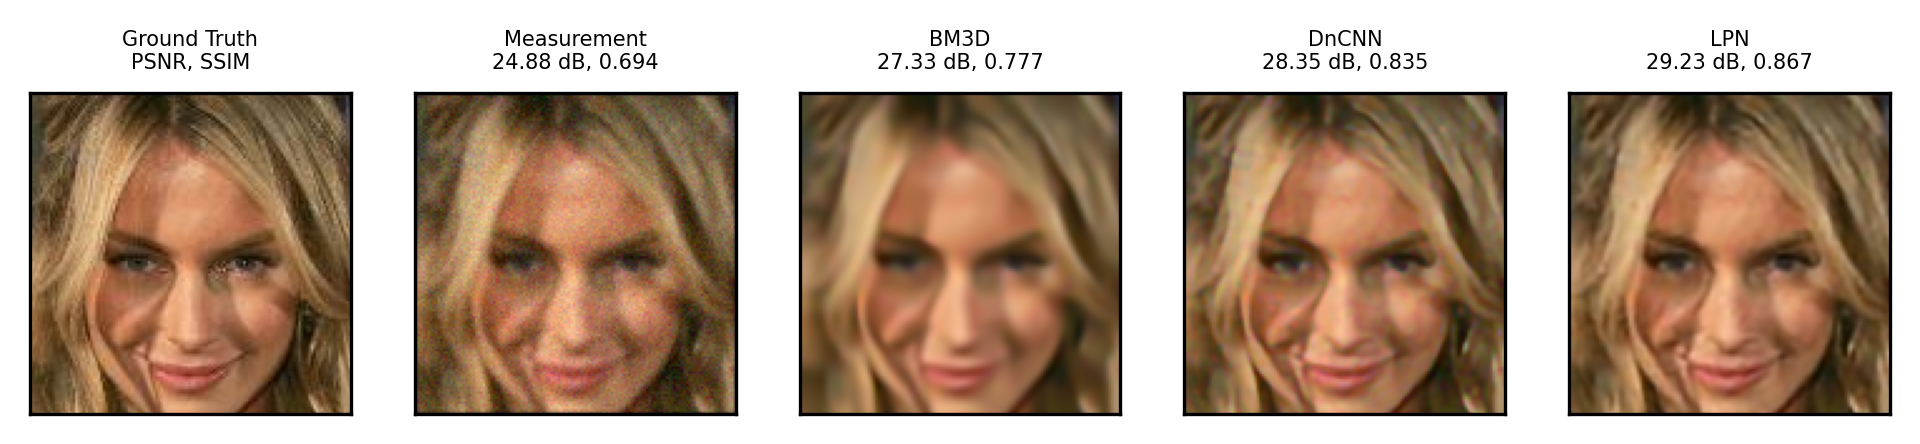

In [31]:
# Visualize results
meas = center_crop(meas, (image_size, image_size))
col_names = ["Ground Truth", "Measurement", "BM3D", "DnCNN", "LPN"]
imgs_list = [img, meas, xhat_dict["bm3d"], xhat_dict["dncnn"], xhat_dict["lpn"]]

nc, nr = len(col_names), 1
figw = 8
figh = figw / nc * nr
fig, axs = plt.subplots(nr, nc, figsize=(figw, figh), dpi=300)

for j in range(nc):
    ax = axs[j]
    ax.imshow(np.clip(imgs_list[j], 0, 1))
    ax.tick_params(labelleft=False, labelbottom=False, left=False, bottom=False)

    if j == 0:
        ax.set_title(col_names[j] + "\n" + "PSNR, SSIM", fontsize=5)
    else:
        psnr = compute_psnr(img, imgs_list[j])
        ssim = compute_ssim(img, imgs_list[j])
        ax.set_title(
            (col_names[j] + "\n" + "{:.2f} dB, {:.3f}".format(psnr, ssim)), fontsize=5
        )

## Subsampling

In [32]:
# Read a test image.
idx = 110
img, _ = dataset[idx]
img = img.numpy()
img = np.transpose(img, (1, 2, 0))

In [33]:
# Define subsampling operator
def downsample_image(img, rate):
    img = snp.mean(snp.reshape(img, (-1, rate, img.shape[1], img.shape[2])), axis=1)
    img = snp.mean(snp.reshape(img, (img.shape[0], -1, rate, img.shape[2])), axis=2)
    return img

In [34]:
# Create a measurement by downsampling and adding Gaussian noise.
rate = 2  # downsampling rate
sigma_noise = 0.02  # noise standard deviation

Afn = lambda x: downsample_image(x, rate=rate)
s = Afn(img)
input_shape = img.shape
output_shape = s.shape
noise, key = scico.random.randn(s.shape, seed=0)
meas = s + sigma_noise * noise

A = linop.LinearOperator(
    input_shape=input_shape, output_shape=output_shape, eval_fn=Afn
)

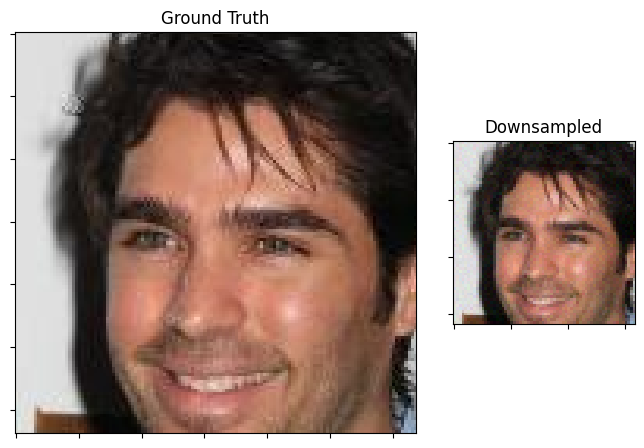

In [35]:
fig = plot.figure(figsize=(8, 6))
ax0 = plot.plt.subplot2grid((1, rate + 1), (0, 0), colspan=rate)
plot.imview(img, title="Ground Truth", fig=fig, ax=ax0)
ax1 = plot.plt.subplot2grid((1, rate + 1), (0, rate))
plot.imview(meas, title="Downsampled", fig=fig, ax=ax1)
fig.show()

In [36]:
# Compute pseudo-inverse solution
xpinv, info = cg(A.T @ A, A.T @ meas, snp.zeros(input_shape))
xpinv = np.asarray(xpinv)

In [37]:
# Run PnP-ADMM with different denoisers
rho = 0.03  # ADMM penalty parameter
maxiter = 12  # number of ADMM iterations


def run_pnp_subsampling(method):
    if method == "lpn":
        g = get_lpn_regularizer()
    elif method == "bm3d":
        lamb = sigma_noise  # BM3D regularization strength
        g = lamb * functional.BM3D()
    elif method == "dncnn":
        g = functional.DnCNN("17M")
    else:
        raise NotImplementedError

    x0 = snp.array(xpinv)
    f = loss.SquaredL2Loss(y=meas, A=A)
    C = linop.Identity(input_shape=input_shape)

    solver = ADMM(
        f=f,
        g_list=[g],
        C_list=[C],
        rho_list=[rho],
        x0=x0,
        maxiter=maxiter,
        subproblem_solver=LinearSubproblemSolver(
            cg_kwargs={"tol": 1e-3, "maxiter": 10}
        ),
        itstat_options={"display": False},
    )

    print(f"Solving on {device_info()}\n")
    xhat = solver.solve()
    return np.array(xhat)


xhat_dict = {}
for method in ["bm3d", "dncnn", "lpn"]:
    print(f"Running PnP with {method} denoiser")
    xhat_dict[method] = run_pnp_subsampling(method)

Running PnP with bm3d denoiser
Solving on CPU

Running PnP with dncnn denoiser
Solving on CPU

Running PnP with lpn denoiser
Solving on CPU



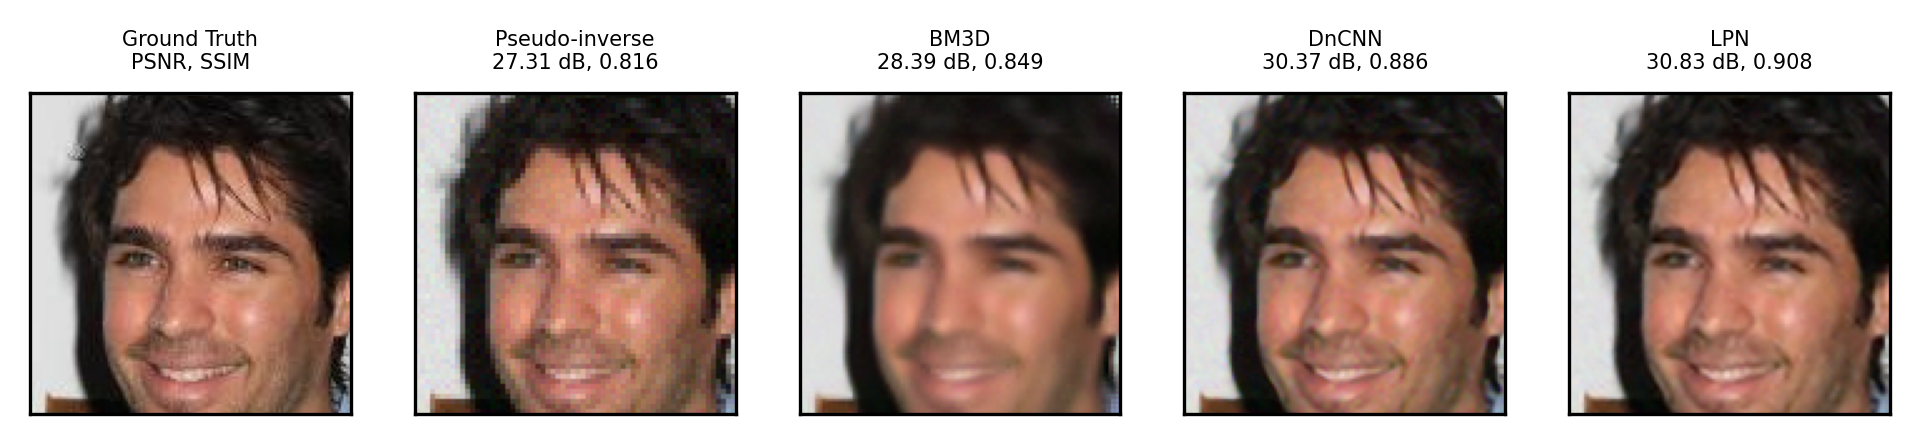

In [38]:
# Visualize results
col_names = ["Ground Truth", "Pseudo-inverse", "BM3D", "DnCNN", "LPN"]
imgs_list = [img, xpinv, xhat_dict["bm3d"], xhat_dict["dncnn"], xhat_dict["lpn"]]

nc, nr = len(col_names), 1
figw = 8
figh = figw / nc * nr
fig, axs = plt.subplots(nr, nc, figsize=(figw, figh), dpi=300)

for j in range(nc):
    ax = axs[j]
    ax.imshow(np.clip(imgs_list[j], 0, 1))
    ax.tick_params(labelleft=False, labelbottom=False, left=False, bottom=False)

    if j == 0:
        ax.set_title(col_names[j] + "\n" + "PSNR, SSIM", fontsize=5)
    else:
        psnr = compute_psnr(img, imgs_list[j])
        ssim = compute_ssim(img, imgs_list[j])
        ax.set_title(
            (col_names[j] + "\n" + "{:.2f} dB, {:.3f}".format(psnr, ssim)), fontsize=5
        )

Acknowledgements
- https://scico.readthedocs.io/en/stable/examples/superres_ppp_dncnn_admm.html